In [1]:
from   matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
from   numpy.random import RandomState
from   scipy.stats import (beta as beta_dist,
                           bernoulli)

from   mfbocd.inference import (bocd,
                                mf_bocd)
from   mfbocd.models import MfBernoulli

color_lf = '#e6550d'
color_hf = '#6baed6'


def gen_data(rng, n_samples, alpha0, beta0, zeta_lf, zeta_hf,cp_prob):
    curr_p = None
    params = np.empty(n_samples)
    cps    = []
    xs     = np.empty((2, n_samples))

    for t in range(0, n_samples):
        if curr_p is None or rng.uniform(0, 1) < cp_prob:
            curr_p = beta_dist(alpha0, beta0).rvs(size=1, random_state=rng)
            cps.append(t)

        params[t] = curr_p
        xs[0, t]  = bernoulli(curr_p * zeta_lf).rvs(size=1, random_state=rng)
        xs[1, t]  = bernoulli(curr_p * zeta_hf).rvs(size=1, random_state=rng)

    return params, xs, cps


def plot_data(ax, params, data, mean, var, colors, markers):
    for mark in ['x', 'o']:
        inds = markers == mark
        xx   = np.where(markers == mark)
        yy   = data[inds]
        if mark == 'x':
            ax.scatter(xx, yy, c=colors[inds], s=20, marker=mark)
        else:
            ax.scatter(xx, yy, s=20, marker=mark, 
                       edgecolors=colors[inds],
                       facecolors='none')
            
    xx = range(0, len(data))
    ax.plot(xx, params, c='k', ls='--')
    ax.plot(xx, mean, c='k', alpha=0.5)
    _2std = 2 * np.sqrt(var)
    ax.plot(xx, mean - _2std, color='k', ls='--', alpha=0.5)
    ax.plot(xx, mean + _2std, color='k', ls='--', alpha=0.5)
    ax.margins(0)
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel(r'Data $\mathbf{x}_t$', fontsize=16)
        

def plot_posterior(ax, R, cps):
    T = len(R)-1
    lnorm = LogNorm(vmin=0.0001, vmax=1)
    ax.imshow(np.rot90(R), aspect='auto', cmap='gray_r', norm=lnorm)
    ax.set_xlim([0, T])
    # This just reverses the y-tick marks.
    ticks = list(range(0, T, 50))
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks[::-1])
    ax.set_ylabel(r'Run length $r_t$', fontsize=16)
    

def get_data_for_viz(inds):
    D = np.empty(T)
    M = []
    C = []
    for t in range(T):
        if inds[t] == 0:
            D[t] = xs[0, :][t]
            M.append('x')
            C.append(color_lf)
        else:
            assert(inds[t] == 1)
            D[t] = xs[1, :][t]
            M.append('o')
            C.append(color_hf)
    C = np.array(C)
    M = np.array(M)
    return D, C, M

## Generate data

In [2]:
alpha0   = 0.1
beta0    = 0.1
zeta_lf  = 0.5
zeta_hf  = 1
T        = 500
cp_prob  = 1./100
rng      = RandomState(seed=None)

params, xs, cps = gen_data(rng, T, alpha0, beta0, zeta_lf, zeta_hf, cp_prob)

## Run MF-BOCD

In [3]:
cost_lf = 1
cost_hf = 1.5
costs   = np.array([cost_lf, cost_hf])
costs   = np.array([cost_lf, cost_hf])
zetas   = np.array([zeta_lf, zeta_hf])

def choose_fid(igs):
    return np.argmax(igs / costs)

model_mf = MfBernoulli(T, zetas, alpha0, beta0)
(inds_mf,
 igs_mf,
 data_mf) = mf_bocd(xs, model_mf, cp_prob, choose_fid)
pct_lowfid_mf = (inds_mf == 0).sum() / len(inds_mf)

print(f'Num. low fidelity: {np.round(pct_lowfid_mf * 100, 2)}')

Num. low fidelity: 50.6


## Visualize results

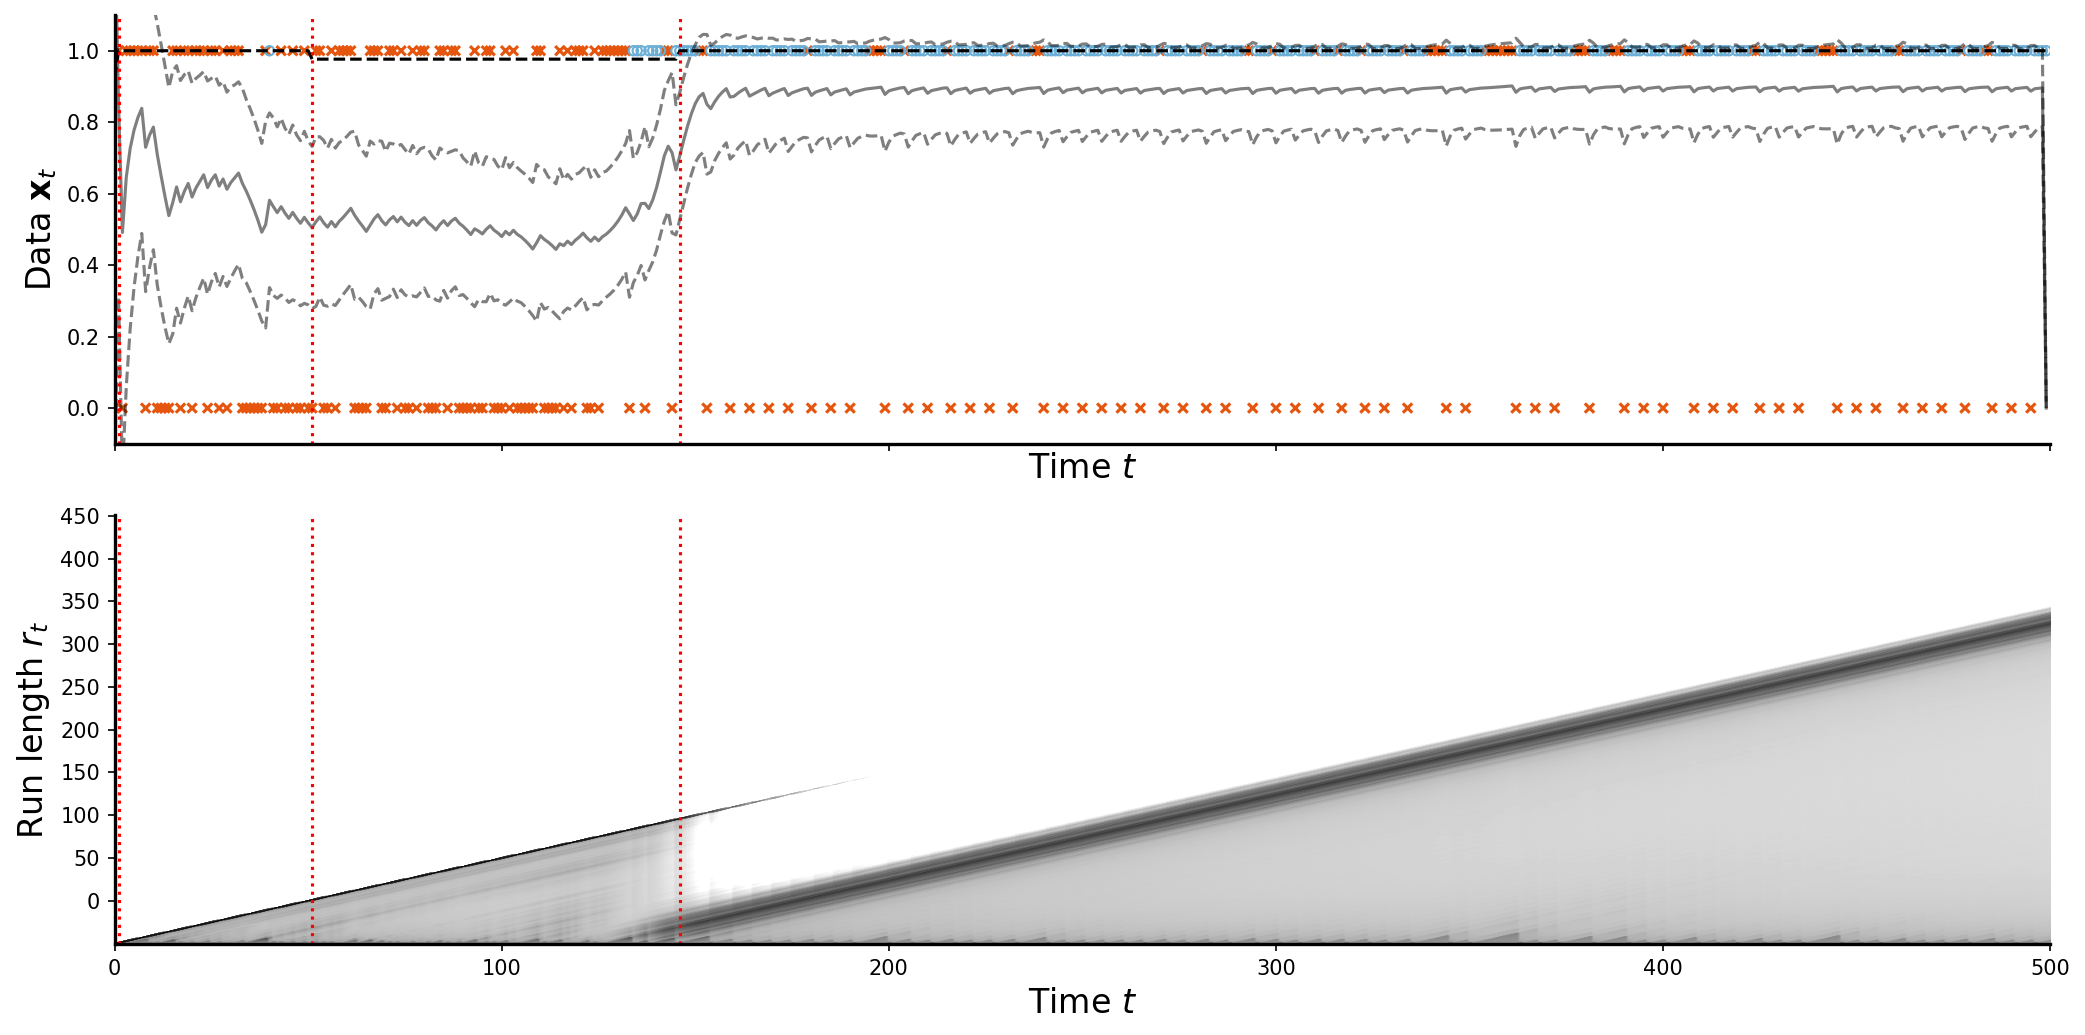

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), dpi=150, sharex=True)

data_mf, colors_mf, markers_mf = get_data_for_viz(inds_mf)
plot_data(ax1, params, data_mf, model_mf._pmean, model_mf._pvar, colors_mf, markers_mf)
plot_posterior(ax2, model_mf._R, cps)

for ax in [ax1, ax2]:
    for cp in cps:
        ax.axvline(cp, c='r', ls='dotted')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(r'Time $t$', fontsize=16)
    [i.set_linewidth(1.6) for i in ax.spines.values()]
        
plt.tight_layout()